In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Import necessary libraries.
import shap
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.stats import chi2_contingency
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('Health_Insurance_Dataset.csv')

# Display basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6978 entries, 0 to 6977
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   total_claim_amount           6978 non-null   float64
 1   medicine_claim               6978 non-null   float64
 2   room_claim                   6978 non-null   float64
 3   diagnostic_claim             6978 non-null   float64
 4   treatment_claim              6978 non-null   float64
 5   proximity_score              6978 non-null   float64
 6   integer_of_Beds              6978 non-null   float64
 7   Hospital_trust_score         6978 non-null   float64
 8   Age                          6978 non-null   int64  
 9   Income_range                 6978 non-null   float64
 10  claim_frequeny_history       6978 non-null   float64
 11  patient_score                6978 non-null   float64
 12  sum_assured                  6978 non-null   float64
 13  sum_assured_left  

In [2]:
# display the first five entries
df.head()

,total_claim_amount,medicine_claim,room_claim,diagnostic_claim,treatment_claim,proximity_score,integer_of_Beds,Hospital_trust_score,Age,Income_range,...,patient_geo_location,gender,policy_type,initial_startdate,start_date,end_date,Policy_benefits,disease_type,multiple_treatement,excessive_prescriptions
0,10000.0,5000.0,3000.0,2000.0,1500.0,8.50,500.0,9.20,45,100000.0,...,"12.4807,77.5946",Male,Individual,01/01/22,05/01/22,10/01/22,"Doctor Visits,Generic $10 co-pay,Annual Wellne...",Cardiovascular Diseases,False,False
1,64474.0,500.0,200.0,300.0,100.0,4.50,100.0,4.20,25,50000.0,...,"40.7128, -74.0060",Female,Individual,NaN,01/02/22,NaN,"Doctor Visits, Generic $10 co-pay",NaN,False,False
2,71993.0,500.0,200.0,300.0,100.0,8.50,200.0,4.20,40,50000.0,...,"12.4767,77.0131",Female,Individual,01/01/22,01/02/22,NaN,"Doctor Visits, Generic $10 co-pay",Cardiovascular disease,False,False
3,3325.0,500.0,1500.0,1000.0,1500.0,8.50,500.0,4.80,30,80000.0,...,"37.7749, -122.4194",Male,Individual,NaN,15/01/22,NaN,"Doctor Visits,Generic $10 co-pay",NaN,False,False
4,1000.5,500.0,300.0,200.0,300.0,8.56,100.0,8.56,45,50000.0,...,"-77.042.1234,38.8977",Male,Individual,01/01/22,10/01/22,15/01/22,"Doctor Visits,Generic $10 co-pay,Annual Wellne...",NaN,False,False


In [3]:
# Summary statistics
df.describe()

,total_claim_amount,medicine_claim,room_claim,diagnostic_claim,treatment_claim,proximity_score,integer_of_Beds,Hospital_trust_score,Age,Income_range,...,lockin_days,medicine_capping,room_capping,diagnostic_capping,treatment_capping,policy_claim_frequency,cost,duration,frequency,fraud_flag
count,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6.978000e+03,...,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000
mean,9483.307546,1110.788199,3297.544723,1083.930197,2111.980046,19.275929,317.773527,14.133792,34.268415,6.884989e+04,...,31.688166,1174.061104,4155.765906,1320.600784,2415.286468,2.799617,8317.655185,22.348214,1.968212,0.500000
std,17388.666073,2959.496766,6905.769487,2674.750043,4925.322121,25.636711,282.143518,24.439463,9.775876,2.236007e+05,...,35.943357,3527.590853,13023.510881,2613.675978,5786.529688,2.319293,14779.615830,27.263235,1.302726,0.500036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.010000,2.000000,5.000000e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,871.417558,172.841030,200.000000,130.680792,100.000000,4.700000,100.000000,4.500000,30.000000,5.000000e+04,...,30.000000,161.917237,300.000000,157.777883,166.672948,1.177764,1000.374558,12.879219,1.000000,0.000000
50%,1500.990000,500.000000,800.000000,300.000000,500.000000,8.200000,200.000000,4.689840,35.000000,5.000000e+04,...,30.000000,500.000000,1000.000000,606.347855,1000.000000,2.000000,5000.000000,14.518859,2.000000,0.500000
75%,10273.131003,589.995786,5000.000000,1685.162157,3000.000000,15.494714,500.000000,8.200000,42.000000,5.000000e+04,...,30.000000,1000.000000,5000.000000,2000.000000,3000.000000,3.285987,11881.524220,27.510965,2.000000,1.000000
max,123456.790000,54321.876500,100000.000000,98765.432100,100000.000000,95.100000,2000.000000,98.765000,65.000000,1.000000e+07,...,365.000000,100000.000000,600000.000000,50000.000000,200000.000000,20.000000,200000.000000,365.000000,30.000000,1.000000


In [4]:
# Check for missing values
df.isnull().sum()

total_claim_amount                0
medicine_claim                    0
room_claim                        0
diagnostic_claim                  0
treatment_claim                   0
proximity_score                   0
integer_of_Beds                   0
Hospital_trust_score              0
Age                               0
Income_range                      0
claim_frequeny_history            0
patient_score                     0
sum_assured                       0
sum_assured_left                  0
lockin_days                       0
medicine_capping                  0
room_capping                      0
diagnostic_capping                0
treatment_capping                 0
policy_claim_frequency            0
cost                              0
duration                          0
frequency                         0
fraud_flag                        0
claim_type                        0
DOA                               1
DOD                             145
claim_status                

In [5]:
# Check for datatypes
df.dtypes

total_claim_amount             float64
medicine_claim                 float64
room_claim                     float64
diagnostic_claim               float64
treatment_claim                float64
proximity_score                float64
integer_of_Beds                float64
Hospital_trust_score           float64
Age                              int64
Income_range                   float64
claim_frequeny_history         float64
patient_score                  float64
sum_assured                    float64
sum_assured_left               float64
lockin_days                    float64
medicine_capping               float64
room_capping                   float64
diagnostic_capping             float64
treatment_capping              float64
policy_claim_frequency         float64
cost                           float64
duration                       float64
frequency                      float64
fraud_flag                       int64
claim_type                      object
DOA                      

In [6]:
# Check distribution of each categorical features
categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    print(f'\n{col} Distribution:')
    print(df[col].value_counts())
    print()


claim_type Distribution:
claim_type
Hospitalization    3198
Daycare            2648
OPD                 571
Domiciliary         561
Name: count, dtype: int64


DOA Distribution:
DOA
01/01/22    5771
01/01/21     450
15/01/22     236
10/01/22     116
01/07/22      81
            ... 
13/12/22       1
25/01/22       1
20/12/21       1
20/01/23       1
10/04/22       1
Name: count, Length: 89, dtype: int64


DOD Distribution:
DOD
15/01/22    1897
10/01/22    1066
05/01/22     561
31/01/22     529
01/02/22     488
            ... 
20/03/23       1
01/05/23       1
14/01/22       1
01/04/21       1
15/03/20       1
Name: count, Length: 163, dtype: int64


claim_status Distribution:
claim_status
Approved    5531
Rejected    1447
Name: count, dtype: int64


claim_date Distribution:
claim_date
10/01/22    1771
05/01/22    1005
01/02/22     897
15/01/22     808
02/01/22     185
            ... 
20/04/21       1
01/09/20       1
15/12/23       1
01/09/22       1
10/03/23       1
Name: count, Le

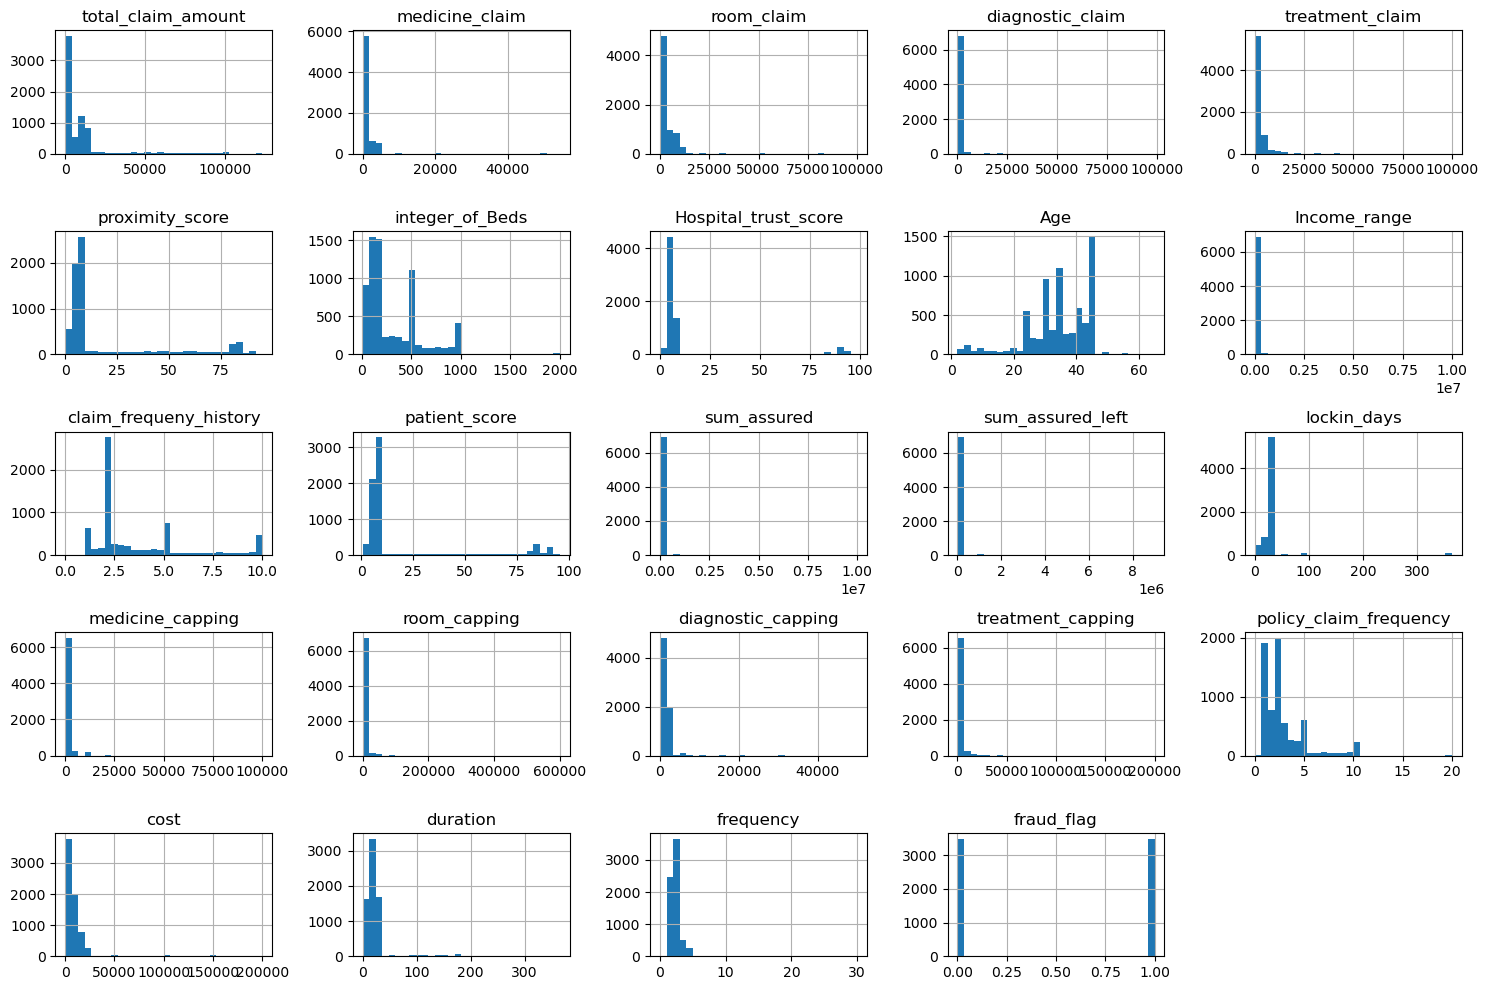

In [7]:
# Plot histograms for numeric columns to check distibution
numeric_features = df.select_dtypes(include=[np.number]).columns
df[numeric_features].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

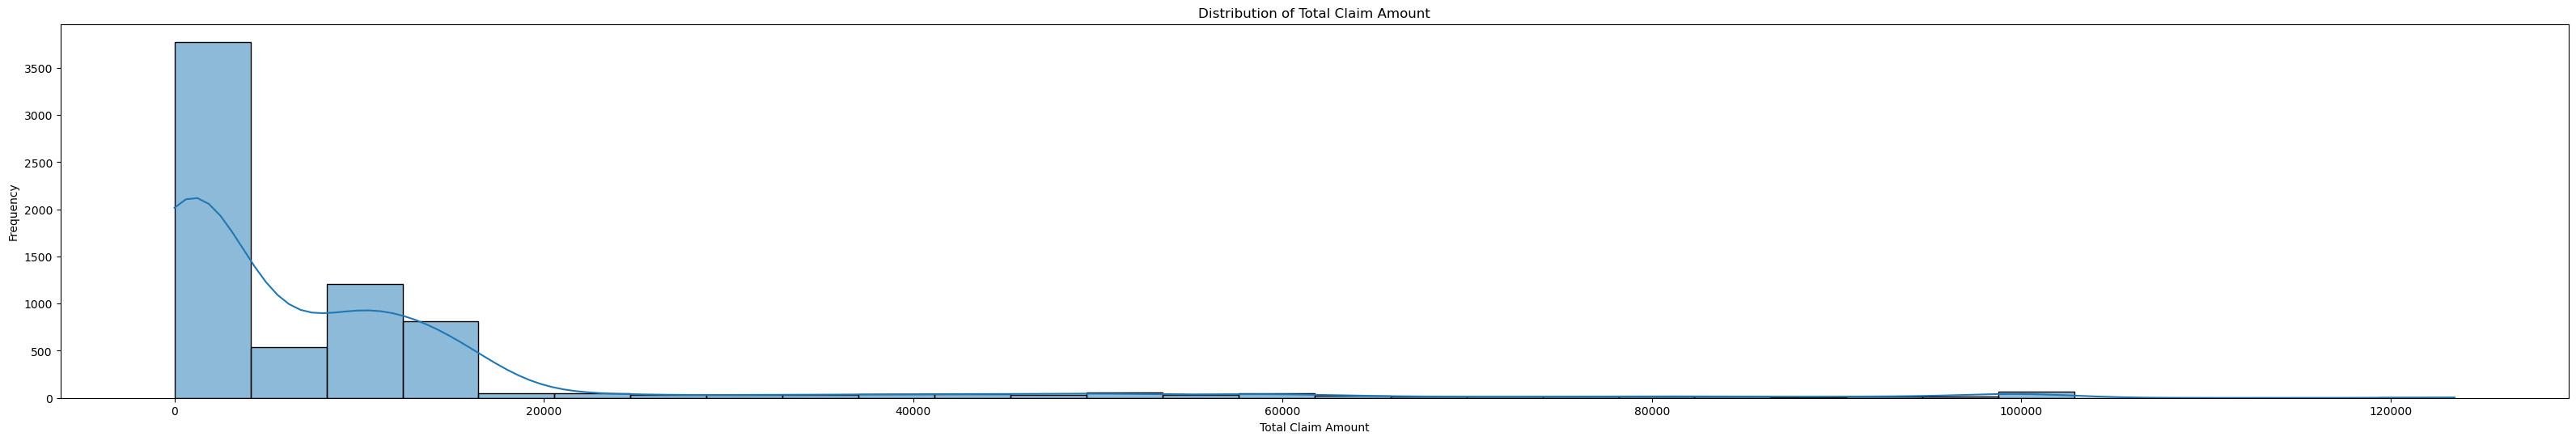

In [8]:
# Distribution of Total Claim Amount
plt.figure(figsize=(40, 6))
sns.histplot(df['total_claim_amount'], bins=30, kde=True)
plt.title('Distribution of Total Claim Amount')
plt.xlabel('Total Claim Amount')
plt.ylabel('Frequency')
plt.show()



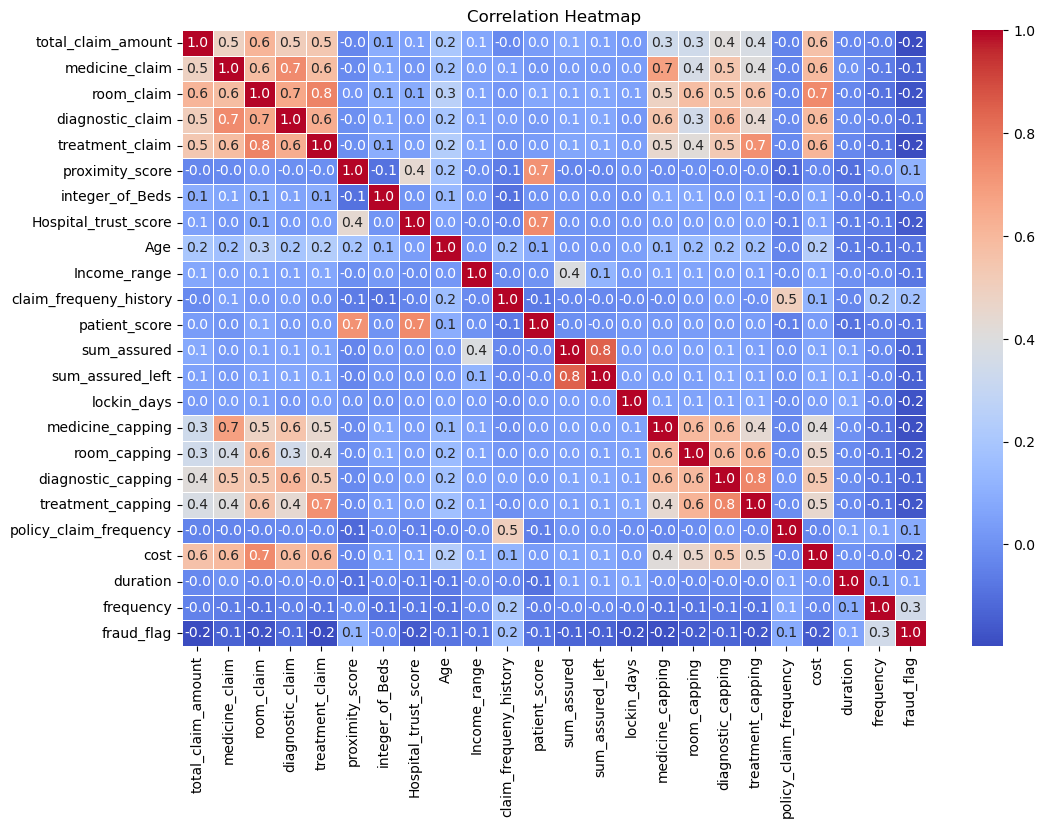

In [9]:
 #Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5,fmt=".1f")
plt.title('Correlation Heatmap')
plt.show()

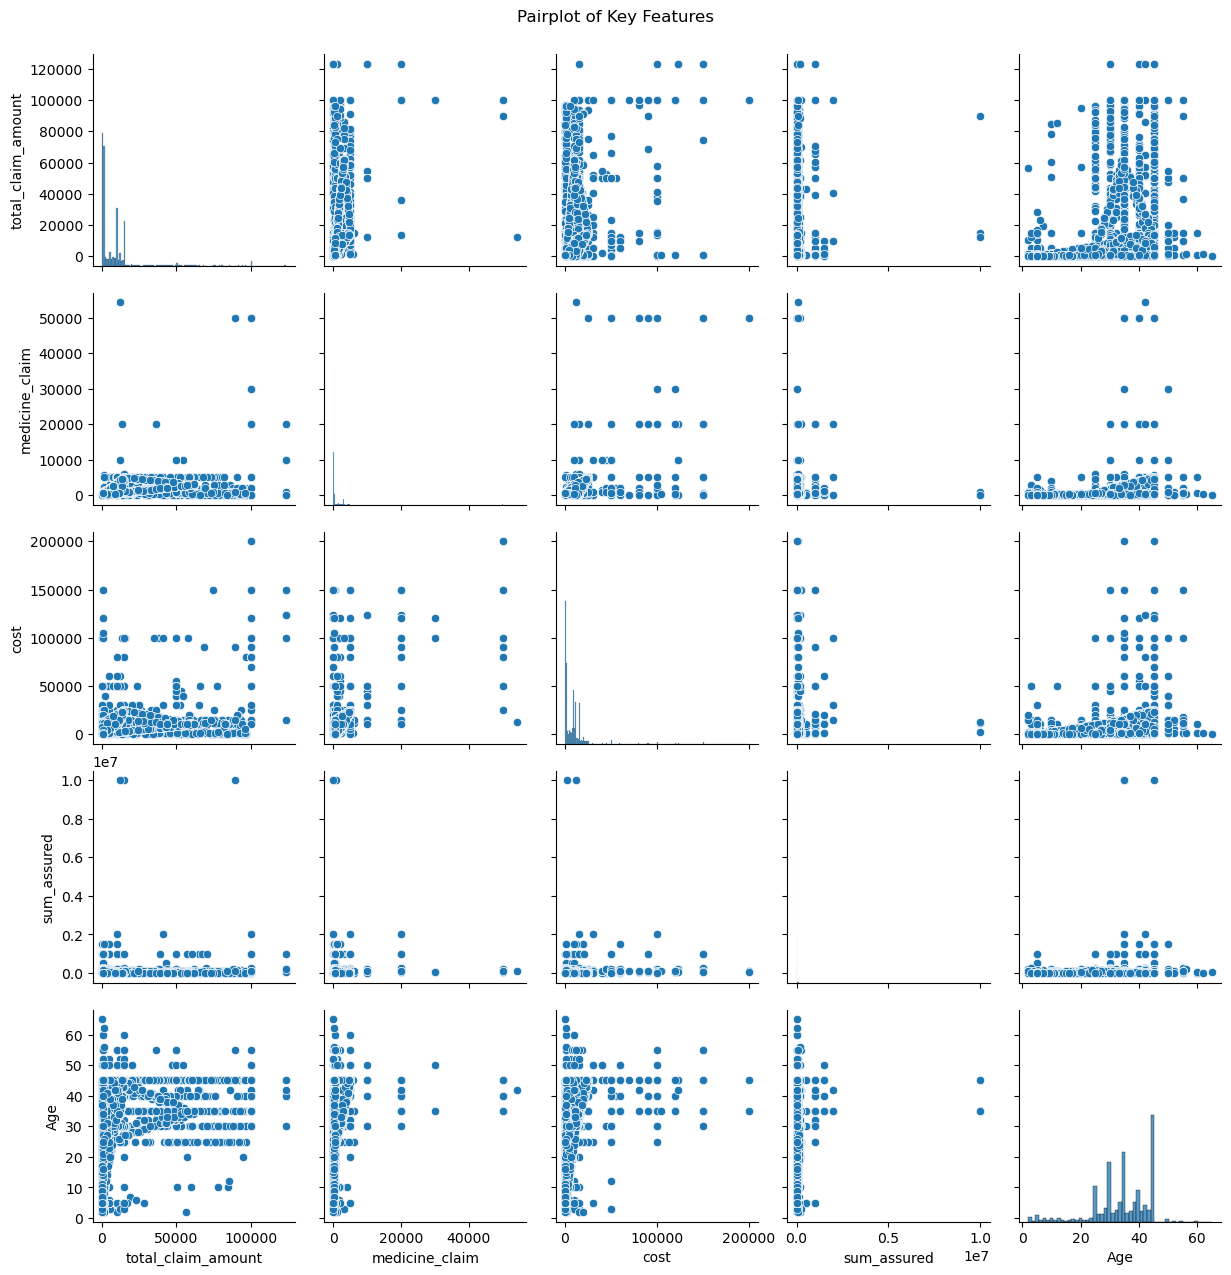

In [10]:
# Pairplot for key numerical features to see potential correlations
sns.pairplot(df[['total_claim_amount', 'medicine_claim', 'cost', 'sum_assured', 'Age']])
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

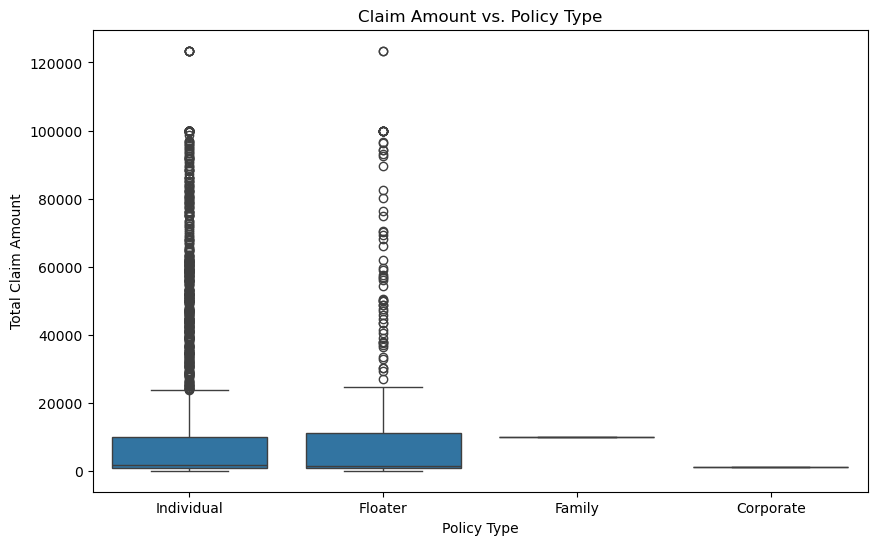

In [11]:
# BoxPlot to understand the different policy type with claim amount
plt.figure(figsize=(10, 6))
sns.boxplot(x='policy_type', y='total_claim_amount', data=df)
plt.title('Claim Amount vs. Policy Type')
plt.xlabel('Policy Type')
plt.ylabel('Total Claim Amount')
plt.show()

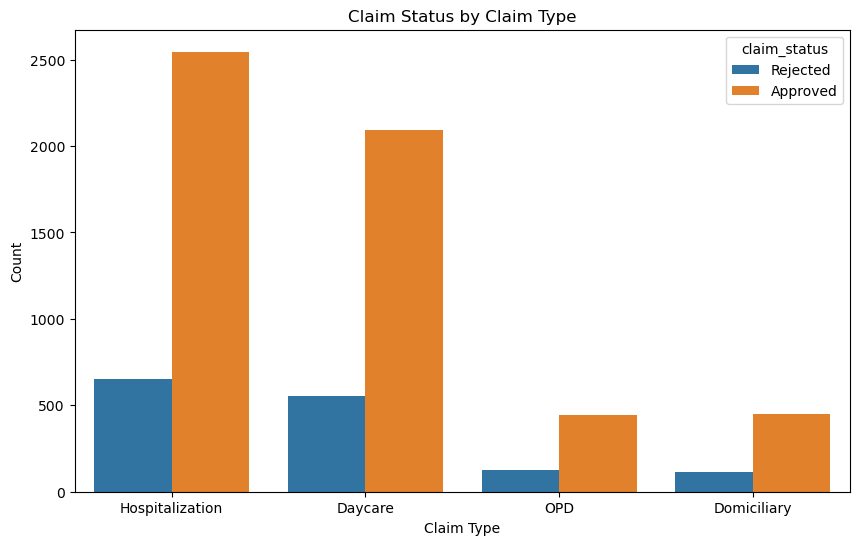

In [12]:
# Plot to understand the claim type and their status
plt.figure(figsize=(10, 6))
sns.countplot(x='claim_type', hue='claim_status', data=df)
plt.title('Claim Status by Claim Type')
plt.xlabel('Claim Type')
plt.ylabel('Count')
plt.show()


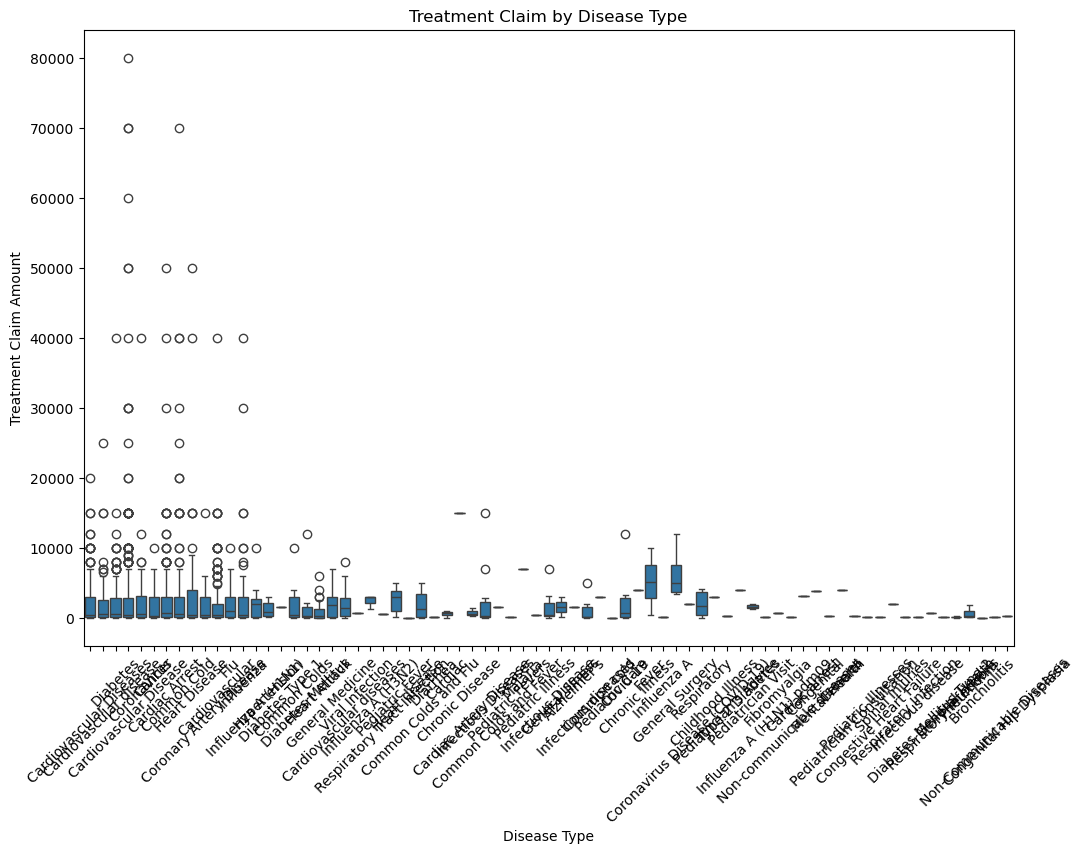

In [13]:
# Boxplot to visualize the distribution of treatment claim amounts
plt.figure(figsize=(12, 8))
sns.boxplot(x='disease_type', y='treatment_claim', data=df)
plt.title('Treatment Claim by Disease Type')
plt.xlabel('Disease Type')
plt.ylabel('Treatment Claim Amount')
plt.xticks(rotation=45)
plt.show()

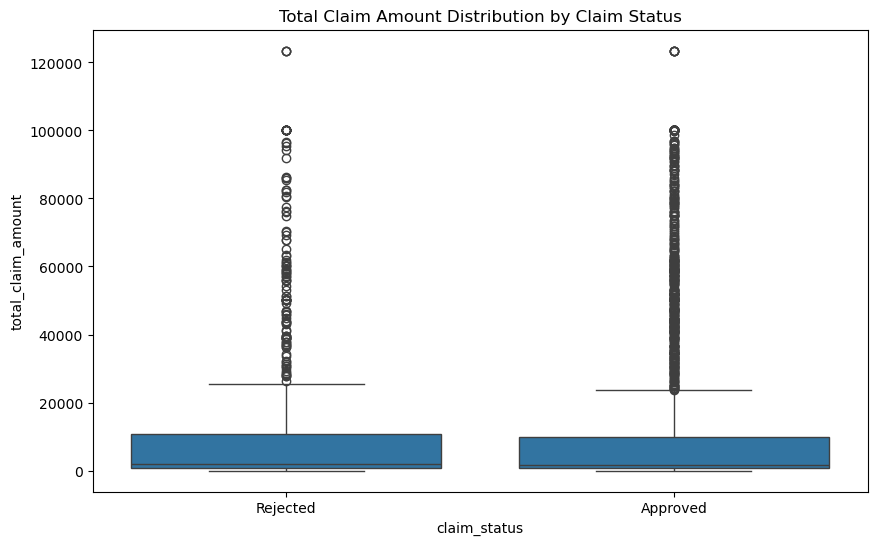

In [14]:
# Ensure 'total_Claim_amount' is numeric, coercing errors to NaN
df['total_claim_amount'] = pd.to_numeric(df['total_claim_amount'], errors='coerce')

# Box Plot - Total Claim Amount by Claim Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='claim_status', y='total_claim_amount')
plt.title('Total Claim Amount Distribution by Claim Status')
plt.show()

In [15]:
# Function to perform Chi-Square test to check relationship between few features and the claim status
def chi_square_test(df, feature):
    contingency_table = pd.crosstab(df[feature], df['claim_status'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-Square Test for '{feature}' and 'claim_status'")
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")
    print("Result: Significant relationship found" if p_value < 0.05 else "Result: No significant relationship found")
    print("-" * 60)

# Running Chi-Square Test on claim-related features
chi_square_test(df, 'claim_type')
chi_square_test(df, 'payment_mode')
chi_square_test(df, 'rejection_reason')
chi_square_test(df, 'Hospital_Type')

Chi-Square Test for 'claim_type' and 'claim_status'
Chi-Square Statistic: 1.1377806235761365
P-value: 0.7679623973768748
Result: No significant relationship found
------------------------------------------------------------
Chi-Square Test for 'payment_mode' and 'claim_status'
Chi-Square Statistic: 0.7445479261813351
P-value: 0.6891654107730218
Result: No significant relationship found
------------------------------------------------------------
Chi-Square Test for 'rejection_reason' and 'claim_status'
Chi-Square Statistic: 6978.0
P-value: 0.0
Result: Significant relationship found
------------------------------------------------------------
Chi-Square Test for 'Hospital_Type' and 'claim_status'
Chi-Square Statistic: 0.5223089739918664
P-value: 0.4698583979498666
Result: No significant relationship found
------------------------------------------------------------


Feature selection using algorithms:
1) SelectKBest
SelectKBest(score_func=f_classif) uses an ANOVA F-test to check how well each independent variable explains the variance in the target variable (claim_status).
The higher the score, the more statistically significant the feature is in predicting the target.

Random forest :

Measures how often a feature was used to split the data in the decision trees, weighted by how much it improves classification.
Values sum to 1.
Zero means the feature was never used by the model.

Lasso applies L1 regularization, which shrinks coefficients and sets some to exactly zero.
The closer to zero, the less important the feature is.
Features with 0 importance are essentially dropped by the model.

In [17]:
# Drop these columns from the original DataFrame
columns_to_drop = ['Hospital_Name', 'Location', 'Patient_unique_id']
df = df.drop(columns=columns_to_drop)

# List of categorical columns to encode
columns_to_encode = ["claim_type", "claim_status", "payment_mode", 
                     "Hospital_Type", "gender", "patient_physical_disability", "multiple_treatement", "rejection_reason", "excessive_prescriptions"]
# Initialize LabelEncoders for each column
label_encoders = {col: LabelEncoder() for col in columns_to_encode}

# Apply Label Encoding and create new columns
for col in columns_to_encode:
    le = LabelEncoder()
    df[col + "_encoded"] = le.fit_transform(df[col])

# Select only numerical columns but EXCLUDE 'Fraud_Flag'
numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64', 'int32']).columns if col != 'fraud_flag']

In [18]:
# Split the data into training and testing sets first
X = df[numerical_cols]
y = df['fraud_flag']

# First, split into train and test sets (90% train, 10% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)

# Then, split the remaining data into train and validation sets (70% train, 20% validation of the 90% remaining)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20/0.90, random_state=42, stratify=y_train_val)

# Print the sizes to confirm the split
print(f"Train set size: {len(X_train)}, Validation set size: {len(X_val)}, Test set size: {len(X_test)}")

# Initialize the imputer (Using Mean Strategy)
imputer = SimpleImputer(strategy="mean") 

# Fit the imputer on the training set only
X_train_imputed = imputer.fit_transform(X_train)

# Apply the imputer to the validation and test sets (using the fitted imputer)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)


# Ensure y_train has valid integer labels
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)


Train set size: 4884, Validation set size: 1396, Test set size: 698


In [19]:
# Feature Selection using SelectKBest
k_best = SelectKBest(score_func=f_classif, k='all')  
k_best.fit(X_train_imputed, y_train)  # Fit on train data only
kbest_feature_importance = pd.Series(
    k_best.scores_, index=X_train.columns  # Ensure correct feature indexing
).sort_values(ascending=False)

# Feature Selection using Random Forest
#rf = RandomForestClassifier(class_weight='balanced')
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_imputed, y_train)
rf_feature_importance = pd.Series(
    rf.feature_importances_, index=X_train.columns  # No dependency on KBest
).sort_values(ascending=False)

# Feature Selection using Lasso (L1 Regularization)
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_imputed, y_train)
lasso_feature_importance = pd.Series(
    np.abs(lasso.coef_), index=X_train.columns  # No dependency on KBest
).sort_values(ascending=False)

# Display SelectKBest Feature Importance
print("SelectKBest Feature Importance:\n")
print(kbest_feature_importance)

# Display Random Forest Feature Importance
print("\nRandom Forest Feature Importance:\n"), 
print(rf_feature_importance)

# Display Lasso Feature Importance
print("\nLasso (L1) Feature Importance:\n")
print(lasso_feature_importance)


SelectKBest Feature Importance:

frequency                              714.123092
total_claim_amount                     201.768976
room_capping                           184.937867
treatment_claim                        184.571444
medicine_capping                       163.521908
lockin_days                            163.109342
treatment_capping                      156.110536
room_claim                             151.356869
claim_frequeny_history                 148.306050
Hospital_trust_score                   133.950109
cost                                   121.123150
sum_assured                            116.719456
sum_assured_left                       111.373449
medicine_claim                          82.815521
diagnostic_capping                      72.502561
proximity_score                         60.244637
diagnostic_claim                        55.271234
patient_score                           45.577392
policy_claim_frequency                  34.544444
Income_range     


 SHAP Feature Importance:

                                Feature  SHAP Importance
22                            frequency         0.132943
19               policy_claim_frequency         0.058624
12                          sum_assured         0.055500
10               claim_frequeny_history         0.040240
14                          lockin_days         0.037533
21                             duration         0.026743
13                     sum_assured_left         0.026656
15                     medicine_capping         0.022552
11                        patient_score         0.021322
7                  Hospital_trust_score         0.020155
5                       proximity_score         0.017722
0                    total_claim_amount         0.017474
8                                   Age         0.010109
4                       treatment_claim         0.009446
6                       integer_of_Beds         0.009213
18                    treatment_capping         0.008905
16 

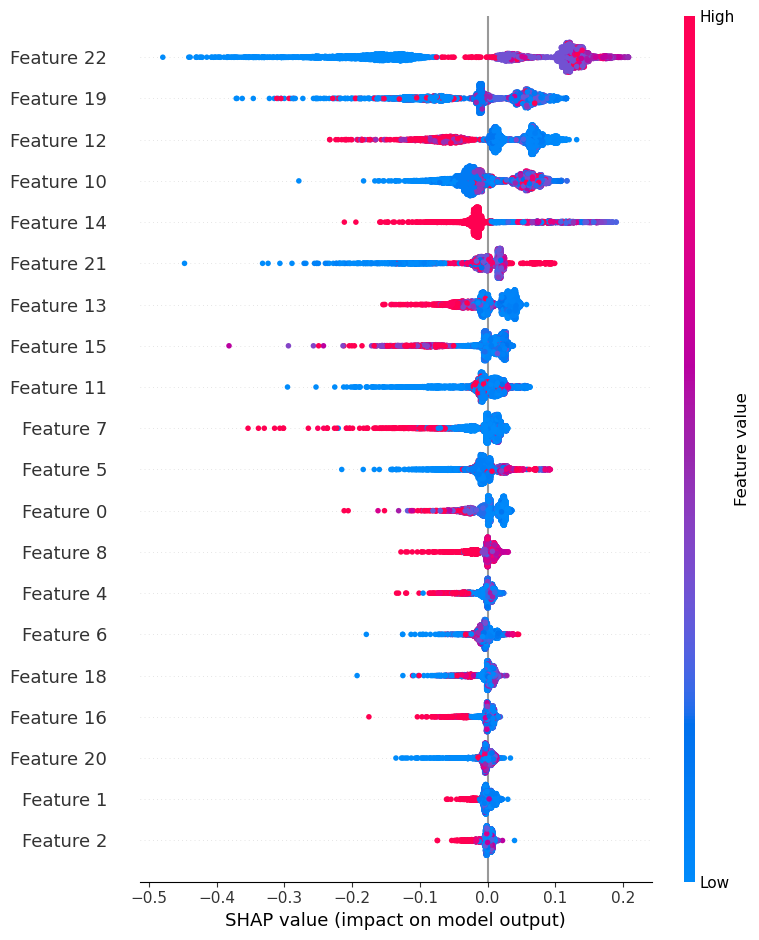

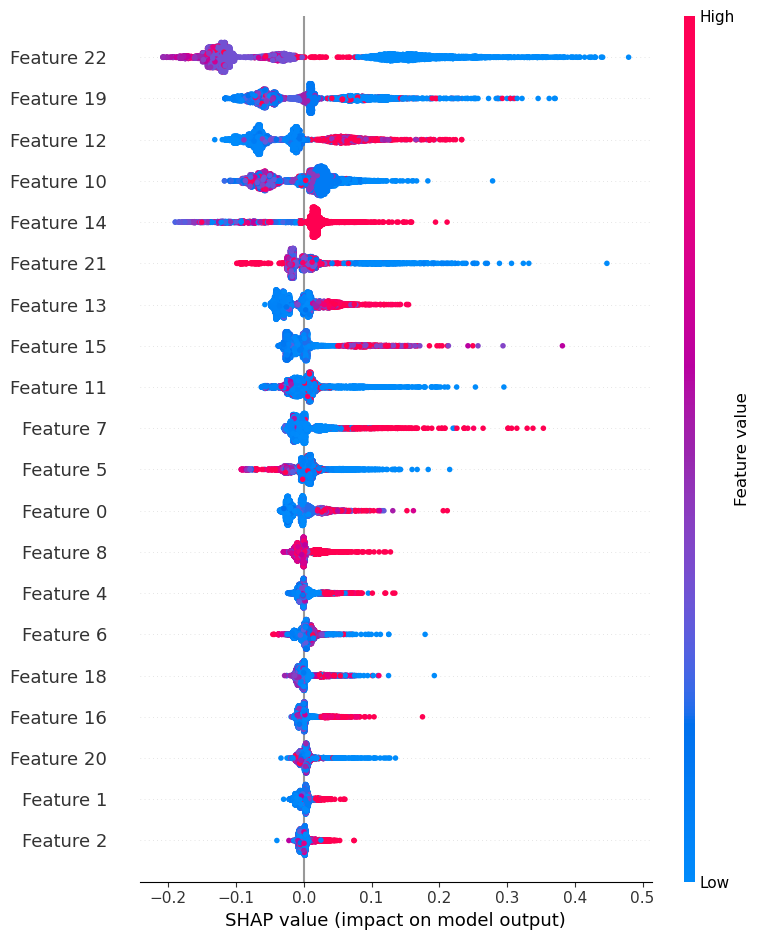

In [20]:
# SHAP Explainer for Tree-Based Model to check feature importance 
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_imputed)  # SHAP values for all classes

# Compute mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values[:, :, 1]).mean(axis=0)  # Taking mean across all samples

# Create a sorted list of feature importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'SHAP Importance': shap_importance})
feature_importance = feature_importance.sort_values(by='SHAP Importance', ascending=False)

# Print top features
print("\n SHAP Feature Importance:\n")
print(feature_importance)

# 🔹 Convert SHAP values to 2D for visualization 
shap_values_class_1 = shap_values[:, :, 1]  # Extract values for Fraud (Class 1)

# 🔹 SHAP Summary Plot for Class 1 (Fraud)
shap.summary_plot(shap_values_class_1, X_train_imputed)

# Extract SHAP values for Class 0 (Non-fraud)
shap_values_class_0 = shap_values[:, :, 0]  # Extract values for Class 0 (Non-fraud)

# SHAP Summary Plot for Class 0
shap.summary_plot(shap_values_class_0, X_train_imputed)

Eigenvalues
[6.20084841e+10 4.39310855e+10]

 Explained Variance Ratio
[0.57863456 0.40994462]
---------------------


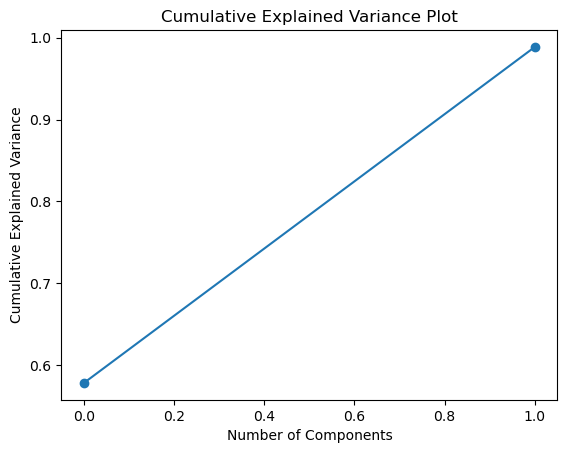

In [21]:
 #Calculating PCA
pca = PCA(0.80)

pct = pca.fit_transform(X_train_imputed)

print("Eigenvalues")
print(pca.explained_variance_)
#print()
#print('eigen vectors')
#print(pca.components_)

print('\n Explained Variance Ratio')
print(pca.explained_variance_ratio_)
print('---------------------')

# Plotting the cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel('Cumulative Explained Variance')
plt.title("Cumulative Explained Variance Plot")
plt.show()


#print(pct.shape)

#X_train_pca, X_test_pca, y_train, y_test = train_test_split(pct, y, test_size=0.2, random_state=42)

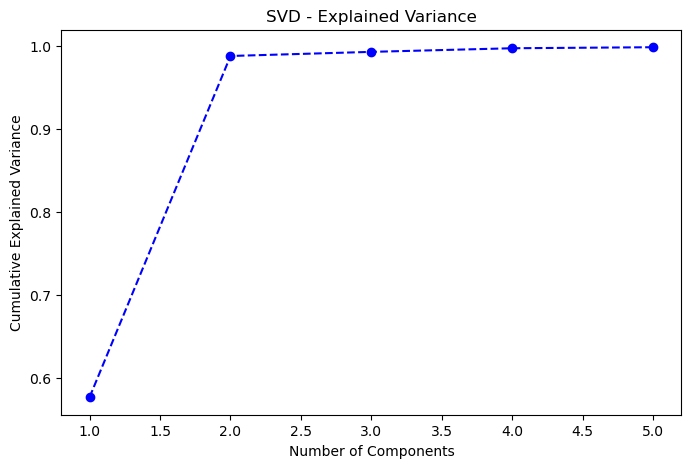

,SVD_Component_1,SVD_Component_2,SVD_Component_3,SVD_Component_4,SVD_Component_5
0,35273.381792,35859.222446,611.641466,664.490876,-380.312641
1,79770.132792,78691.528988,-2304.614488,1656.012727,73.135702
2,57411.007994,31466.312226,16451.269121,86.273175,-3393.406850
3,136210.496791,-44585.634265,-2098.604235,7581.449017,25.613501
4,160664.098199,576.557457,20054.780890,-3039.371255,-1892.807000


In [22]:
# Apply Truncated SVD (keeping top 5 components based on pca analysis)
k = min(5, X_train.shape[1])
svd = TruncatedSVD(n_components=k)
svd_transformed = svd.fit_transform(X_train_imputed)

# Explained variance ratio
explained_variance = svd.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Plot explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, k+1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD - Explained Variance')
plt.show()

# Create a separate DataFrame for the SVD components
svd_df = pd.DataFrame(svd_transformed, columns=[f'SVD_Component_{i+1}' for i in range(k)])

# check first five entries
svd_df.head()



In [23]:
# Print the first few rows of the SVD transformed values
svd_transformed

array([[ 3.52733818e+04,  3.58592224e+04,  6.11641466e+02,
         6.64490876e+02, -3.80312641e+02],
       [ 7.97701328e+04,  7.86915290e+04, -2.30461449e+03,
         1.65601273e+03,  7.31357023e+01],
       [ 5.74110080e+04,  3.14663122e+04,  1.64512691e+04,
         8.62731746e+01, -3.39340685e+03],
       ...,
       [ 2.26629788e+05, -1.16397260e+05, -4.18093814e+03,
        -8.62905236e+03,  8.59852129e+02],
       [ 4.18410546e+04,  3.05802790e+04, -9.87860395e+02,
         1.47302858e+03,  1.31603119e+02],
       [ 4.99599678e+04,  2.46948856e+04,  1.97166154e+04,
         3.34262339e+02, -3.96739868e+03]])

In [24]:
# Select top 25 features for model building based on importance seen through each algorithm.
selected_features = kbest_feature_importance.head(25).index.tolist()

# Get the indices of the selected features
selected_features_numeric = [X_train.columns.get_loc(feature) for feature in selected_features]

# Select the columns corresponding to the selected features from the imputed data
X_train_selected = X_train_imputed[:, selected_features_numeric]
X_test_selected = X_test_imputed[:, selected_features_numeric]
X_val_selected = X_val_imputed[:, selected_features_numeric]


# Standardization
scaler = StandardScaler()

# Fit the scaler on the training set only
X_train_scaled = scaler.fit_transform(X_train_selected)

# Apply the same scaler to the validation and test sets
X_val_scaled = scaler.transform(X_val_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Save the scaler to use it during inference
joblib.dump(scaler, "scaler.joblib")    

['scaler.joblib']

Accuracy: 0.8760744985673352
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       698
           1       0.84      0.93      0.88       698

    accuracy                           0.88      1396
   macro avg       0.88      0.88      0.88      1396
weighted avg       0.88      0.88      0.88      1396

Confusion Matrix:
 [[576 122]
 [ 51 647]]


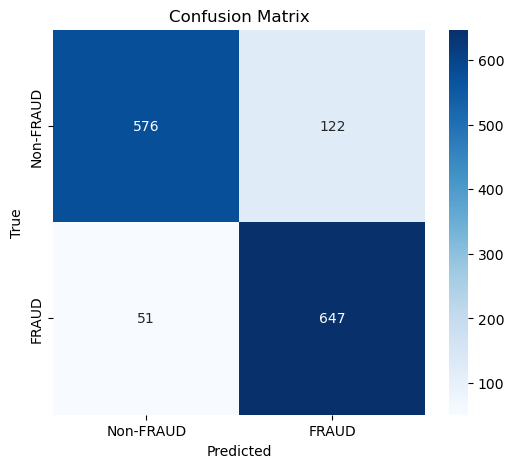

ROC-AUC Score: 0.9223220663212945


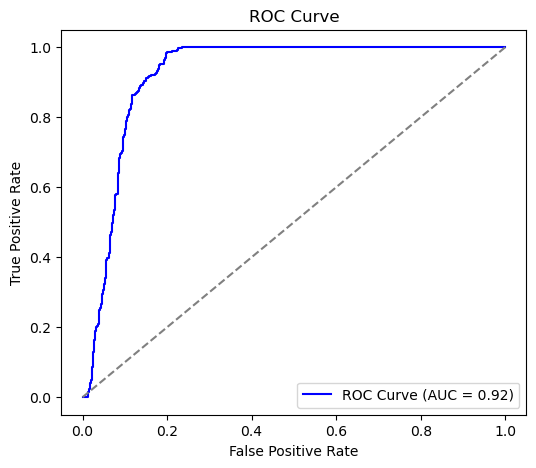

In [25]:
# Initialize and train Logistic Regression
log_reg = LogisticRegression(solver='lbfgs')  # Standard solver for binary classification
log_reg.fit(X_train_scaled, y_train)

# Make predictions on validation data
y_pred_LR = log_reg.predict(X_val_scaled)

# Evaluate model
print("Accuracy:", accuracy_score(y_val, y_pred_LR))
print(classification_report(y_val, y_pred_LR))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_LR)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-FRAUD', 'FRAUD'], yticklabels=['Non-FRAUD', 'FRAUD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC-AUC score (Receiver Operating Characteristic - Area Under Curve)
roc_auc = roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:, 1])  # Predict probabilities for class 1
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, log_reg.predict_proba(X_val_scaled)[:, 1])
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.9964183381088825
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       698
           1       1.00      1.00      1.00       698

    accuracy                           1.00      1396
   macro avg       1.00      1.00      1.00      1396
weighted avg       1.00      1.00      1.00      1396

Confusion Matrix:
 [[696   2]
 [  3 695]]


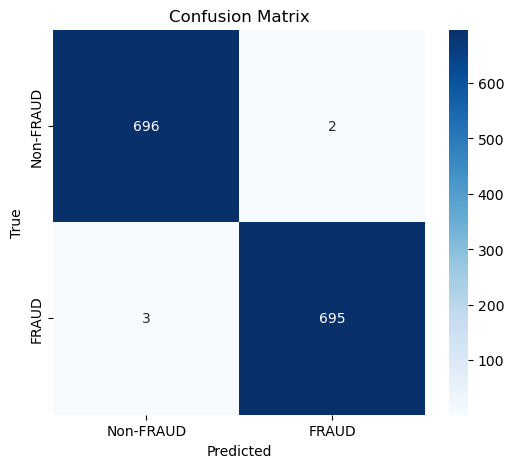

ROC-AUC Score: 0.9998942947923252


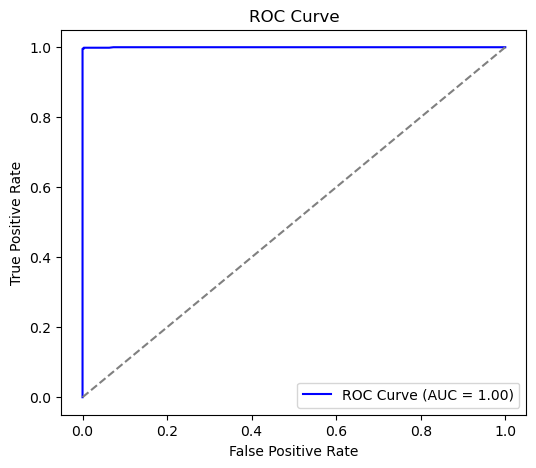

In [26]:
# Make predictions
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_scaled, y_train)
y_pred_RF = rf_selected.predict(X_val_scaled)

# Evaluate model
print("Accuracy:", accuracy_score(y_val, y_pred_RF))
print("Classification Report:\n", classification_report(y_val, y_pred_RF))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_RF)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-FRAUD', 'FRAUD'], yticklabels=['Non-FRAUD', 'FRAUD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC-AUC score (Receiver Operating Characteristic - Area Under Curve)
roc_auc = roc_auc_score(y_val, rf_selected.predict_proba(X_val_scaled)[:, 1])  # Predict probabilities for class 1
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, rf_selected.predict_proba(X_val_scaled)[:, 1])
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Validation Accuracy: 0.9971
Confusion Matrix:
[[696   2]
 [  2 696]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       698
           1       1.00      1.00      1.00       698

    accuracy                           1.00      1396
   macro avg       1.00      1.00      1.00      1396
weighted avg       1.00      1.00      1.00      1396

ROC AUC Score: 0.9999


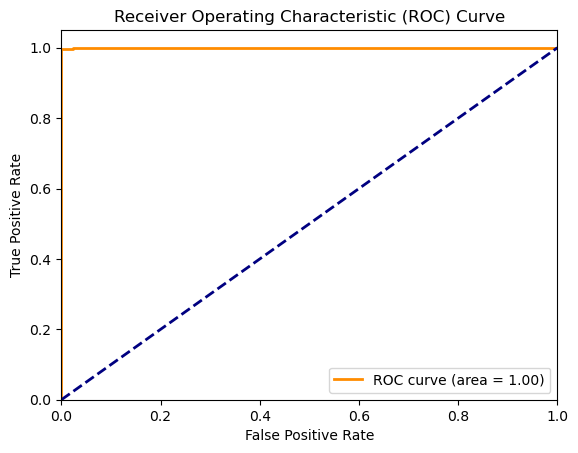

In [27]:
# Create the XGBoost model (Classifier for classification task)
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',   # 'binary:logistic' for binary classification; use 'multi:softmax' for multi-class
    eval_metric='logloss',         # Evaluation metric for binary classification
    use_label_encoder=False,       # Avoid deprecated label encoding warnings
    n_estimators=100,              # Number of boosting rounds (trees)
    learning_rate=0.1,             # Learning rate (step size)
    max_depth=6,                   # Maximum depth of each tree
    colsample_bytree=0.8,          # Fraction of features to use for each tree
    subsample=0.8                  # Fraction of samples to use for each tree
)

# Fit the model on the training data
model_xgb.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_pred_xgb = model_xgb.predict(X_val_scaled)
y_pred_proba_xgb = model_xgb.predict_proba(X_val_scaled)[:, 1]  # For ROC AUC, get the probabilities for the positive class

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"Validation Accuracy: {accuracy:.4f}")

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))

print("Classification Report:")
print(classification_report(y_val, y_pred_xgb))

# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba_xgb)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_xgb)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - AUC: 0.5150 - Precision: 0.5131 - Recall: 0.7955 - accuracy: 0.5166 - loss: 0.7768 - val_AUC: 0.7683 - val_Precision: 0.8504 - val_Recall: 0.2851 - val_accuracy: 0.6175 - val_loss: 0.6758
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7744 - Precision: 0.6790 - Recall: 0.7397 - accuracy: 0.7011 - loss: 0.5767 - val_AUC: 0.9368 - val_Precision: 0.8043 - val_Recall: 0.9713 - val_accuracy: 0.8675 - val_loss: 0.5078
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9148 - Precision: 0.8282 - Recall: 0.8598 - accuracy: 0.8389 - loss: 0.3858 - val_AUC: 0.9755 - val_Precision: 0.8041 - val_Recall: 1.0000 - val_accuracy: 0.8782 - val_loss: 0.2903
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9537 - Precision: 0.8649 - Recall: 0.9278 - accuracy: 0.8914 - loss: 0.2717 - val_AUC: 0.9831 - val_Precision: 0.8554 - val_Recall: 1.0000 - val_accuracy: 0.9155 - val_loss: 0.2279
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━

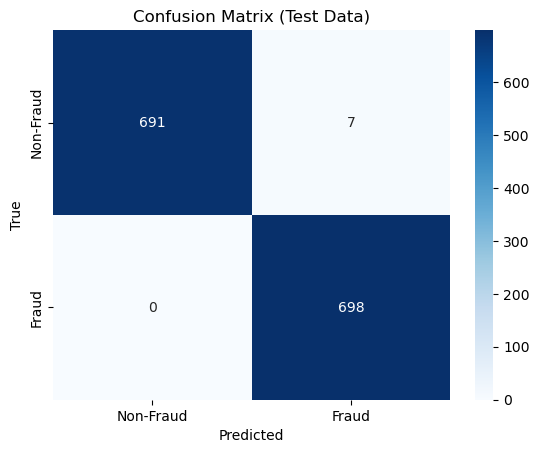

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       698
           1       0.99      1.00      1.00       698

    accuracy                           0.99      1396
   macro avg       1.00      0.99      0.99      1396
weighted avg       1.00      0.99      0.99      1396



In [28]:
# Define the model
model_DL = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(8, activation='relu'),
    
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_DL.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['AUC', 'Precision', 'Recall', 'accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_DL.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val), 
                    epochs=100, 
                    batch_size=64, 
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate the model
results = model_DL.evaluate(X_val_scaled, y_val, verbose=0)

# Optionally, print the evaluation results
print(f"Validation Loss: {results[0]}")
print(f"Validation AUC: {results[1]}")
print(f"Validation Precision: {results[2]}")
print(f"Validation Recall: {results[3]}")
print(f"Validation Accuracy: {results[4]}")


# Make predictions on the validation or test data
y_pred_dl = model_DL.predict(X_val_scaled)  # For validation data
y_pred_dl_class = (y_pred_dl > 0.5).astype(int)  # Convert probabilities to class labels

# Calculate the ROC AUC score
roc_auc_dl = roc_auc_score(y_val, y_pred_dl)
print(f"ROC AUC Score for Deep Learning Model: {roc_auc_dl:.4f}")

# Optionally, plot confusion matrix or classification report
print("\nConfusion Matrix:")
cm_dl_val = confusion_matrix(y_val, y_pred_dl_class)
sns.heatmap(cm_dl_val, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()

print("Classification Report:")
print(classification_report(y_val, y_pred_dl_class))

Check each model accuracy on Test Data which was not exposed till now.

Logistic Regression 

Test Accuracy: 0.8897
Test ROC AUC Score: 0.9295
Confusion Matrix:


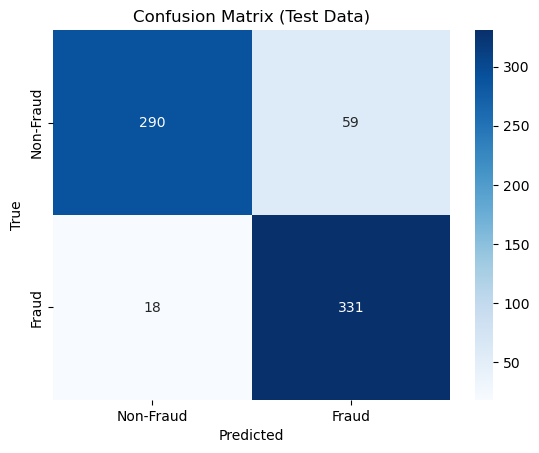

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       349
           1       0.85      0.95      0.90       349

    accuracy                           0.89       698
   macro avg       0.90      0.89      0.89       698
weighted avg       0.90      0.89      0.89       698



In [31]:
y_test_pred_LR = log_reg.predict(X_test_scaled)
y_test_pred_proba_LR = log_reg.predict_proba(X_test_scaled)[:, 1]

test_accuracy_LR = accuracy_score(y_test, y_test_pred_LR)
print(f"Test Accuracy: {test_accuracy_LR:.4f}")

# Test ROC AUC Score
test_roc_auc_LR = roc_auc_score(y_test, y_test_pred_proba_LR)
print(f"Test ROC AUC Score: {test_roc_auc_LR:.4f}")

# Optionally, plot confusion matrix or classification report
print("Confusion Matrix:")
cm_dl_test = confusion_matrix(y_test, y_test_pred_LR)
sns.heatmap(cm_dl_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_test_pred_LR))

Random Forest 

Test Accuracy: 1.0000
Test ROC AUC Score: 1.0000
Confusion Matrix:


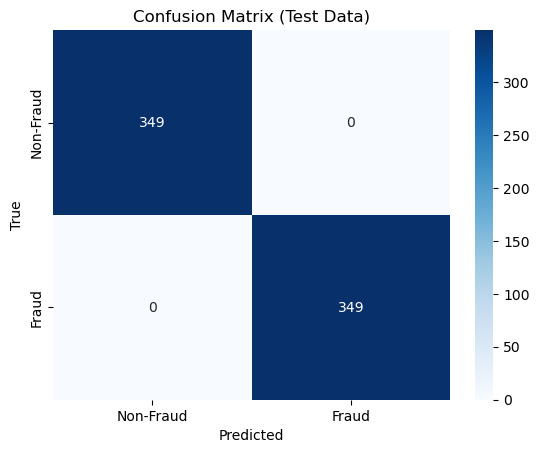

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       349
           1       1.00      1.00      1.00       349

    accuracy                           1.00       698
   macro avg       1.00      1.00      1.00       698
weighted avg       1.00      1.00      1.00       698



In [33]:
y_test_pred_RF = rf_selected.predict(X_test_scaled)
y_test_pred_proba_RF = rf_selected.predict_proba(X_test_scaled)[:, 1]

test_accuracy_RF = accuracy_score(y_test, y_test_pred_RF)
print(f"Test Accuracy: {test_accuracy_RF:.4f}")

# Test ROC AUC Score
test_roc_auc_RF = roc_auc_score(y_test, y_test_pred_proba_RF)
print(f"Test ROC AUC Score: {test_roc_auc_RF:.4f}")

# Optionally, plot confusion matrix or classification report
print("Confusion Matrix:")
cm_dl_test = confusion_matrix(y_test, y_test_pred_RF)
sns.heatmap(cm_dl_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_test_pred_RF))

XGBoost

Test Accuracy: 1.0000
Test ROC AUC Score: 1.0000
Confusion Matrix:


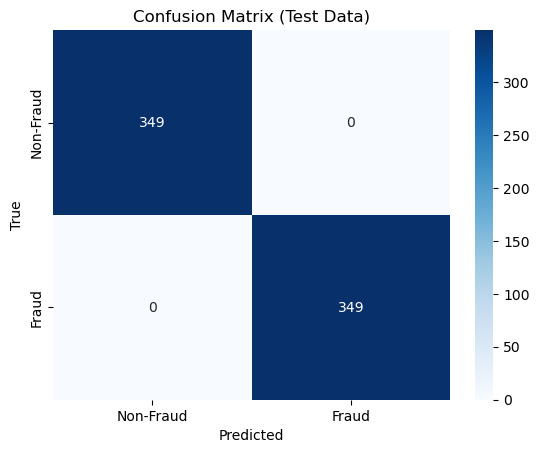

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       349
           1       1.00      1.00      1.00       349

    accuracy                           1.00       698
   macro avg       1.00      1.00      1.00       698
weighted avg       1.00      1.00      1.00       698



In [35]:
# Optionally, you can evaluate on the test set as well
y_test_pred_xgb = model_xgb.predict(X_test_scaled)
y_test_pred_proba_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]  # For ROC AUC on test set

test_accuracy = accuracy_score(y_test, y_test_pred_xgb)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Test ROC AUC Score
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba_xgb)
print(f"Test ROC AUC Score: {test_roc_auc:.4f}")

# Optionally, plot confusion matrix or classification report
print("Confusion Matrix:")
cm_dl_test = confusion_matrix(y_test, y_test_pred_xgb)
sns.heatmap(cm_dl_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_test_pred_xgb))

DeepLearning

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Accuracy (Deep Learning): 0.9943
ROC AUC Score for Deep Learning Model: 0.9943

Confusion Matrix:


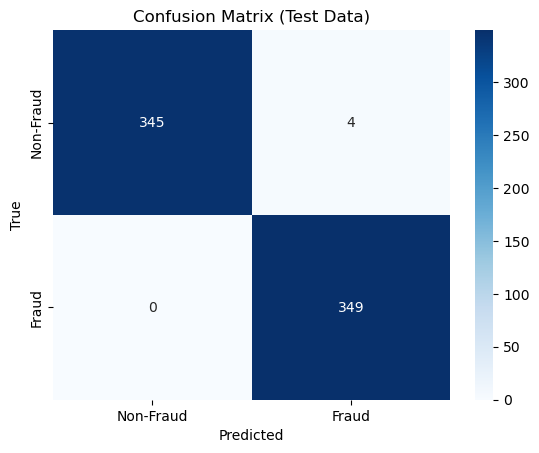

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       349
           1       0.99      1.00      0.99       349

    accuracy                           0.99       698
   macro avg       0.99      0.99      0.99       698
weighted avg       0.99      0.99      0.99       698



In [37]:
# 1. Make predictions using the trained deep learning model
y_pred_dl_test = model_DL.predict(X_test_scaled)  # Predict the probabilities for the test data
# 2. Convert probabilities to class labels (for binary classification)
y_pred_dl_test = (y_pred_dl_test > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

# 3. Evaluate the model on the test data
accuracy_test_dl = accuracy_score(y_test, y_pred_dl_test)
# Print evaluation metrics
print(f"Test Accuracy (Deep Learning): {accuracy_test_dl:.4f}")

# Calculate the ROC AUC score
roc_auc_dl = roc_auc_score(y_test, y_pred_dl_test)
print(f"ROC AUC Score for Deep Learning Model: {roc_auc_dl:.4f}")

# Optionally, plot confusion matrix or classification report
print("\nConfusion Matrix:")
cm_dl_test = confusion_matrix(y_test, y_pred_dl_test)
sns.heatmap(cm_dl_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_dl_test))

Based on above model accuracy, classification report & confusion Matrix, we select 3 models for API building i.e. XGboost, RandomForest, DeepLearning.

In [39]:
# Save the models for API building.
joblib.dump(rf_selected, 'random_forest_model.joblib')
model_xgb.save_model("xgb_model.json")
model_DL.save("deep_learning_model.keras")